In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


2024-01-20 23:45:36.241452: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/alitahseen/Desktop/FYP-2024/Machine_learning/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
# Load the datasets
train_data = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/train1.csv')
test_data = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/test1.csv')


In [5]:
# Make copies for LEAR model
train_data_lear = train_data.copy()
test_data_lear = test_data.copy()

# Make copies for DNN model
train_data_dnn = train_data.copy()
test_data_dnn = test_data.copy()

In [7]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Convert 'Datetime' to datetime object and sort data
train_data_lear['Datetime'] = pd.to_datetime(train_data_lear['Datetime'])
train_data_lear.sort_values('Datetime', inplace=True)
test_data_lear['Datetime'] = pd.to_datetime(test_data_lear['Datetime'])
test_data_lear.sort_values('Datetime', inplace=True)

# Extract datetime features
train_data_lear['hour'] = train_data_lear['Datetime'].dt.hour
train_data_lear['day_of_week'] = train_data_lear['Datetime'].dt.dayofweek
train_data_lear['month'] = train_data_lear['Datetime'].dt.month
test_data_lear['hour'] = test_data_lear['Datetime'].dt.hour
test_data_lear['day_of_week'] = test_data_lear['Datetime'].dt.dayofweek
test_data_lear['month'] = test_data_lear['Datetime'].dt.month

# Function to create lagged features
def create_lagged_features(df, target, lag_days):
    for lag in lag_days:
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)
    return df.dropna()

# Create lagged features
lag_days = [1, 2, 7]
train_data_lear = create_lagged_features(train_data_lear, 'MW', lag_days)
test_data_lear = create_lagged_features(test_data_lear, 'MW', lag_days)

# Prepare training and testing data
X_train_lear = train_data_lear.drop(['MW', 'Datetime'], axis=1)  # Retain 'Average_Temp'
y_train_lear = train_data_lear['MW']
X_test_lear = test_data_lear.drop(['MW', 'Datetime'], axis=1)  # Retain 'Average_Temp'
y_test_lear = test_data_lear['MW']

# Initialize and train the Lasso model
lear_model = Lasso(alpha=0.1)
lear_model.fit(X_train_lear, y_train_lear)

# Make predictions with LEAR model
lear_predictions = lear_model.predict(X_test_lear)

# Function to calculate metrics
def calculate_metrics(actual, predicted, threshold=1):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Filter out pairs where the actual value is less than or equal to the threshold
    valid_actual = actual[actual > threshold]
    corresponding_predicted = predicted[actual > threshold]

    # Calculate MAPE for valid actual values
    mape = np.mean(np.abs((valid_actual - corresponding_predicted) / valid_actual)) * 100

    # Calculate sMAPE
    smape = 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    # Get the pairs that were excluded
    excluded_pairs = [(act, pred) for act, pred in zip(actual, predicted) if act <= threshold]

    return mae, mape, smape, rmse, excluded_pairs

# Calculate metrics
mae, mape, smape, rmse, excluded_pairs = calculate_metrics(y_test_lear, lear_predictions)

# Print the metrics
print("LEAR Metrics:")
print("MAE:", mae)
print("MAPE:", mape)
print("sMAPE:", smape)
print("RMSE:", rmse)

# Print the excluded pairs
print("Excluded pairs (Actual, Predicted):", excluded_pairs)



LEAR Metrics:
MAE: 6.545402962588864
MAPE: 15.478280377819322
sMAPE: 15.791825972757115
RMSE: 13.24641656746003
Excluded pairs (Actual, Predicted): [(-0.03183, 6.15847663506325), (-1.68827, 6.68903747600638), (-3.04641, 6.8416338371262775), (-3.36158, 5.109107051892691), (-1.89195, 1.890274755426244), (0.01, 2.0869022261925947), (0.70807, -3.4376331331366927), (-2.44903, 6.36285518824597), (-3.81538, 3.2801772699144784), (-4.75788, 4.0725739980767575), (-5.04993, 2.5356572862856055), (-3.34572, -0.580207643108519), (-0.0111, 0.3683791028664172), (-1.0466, 13.373063230466263), (-0.07002, 9.038278164128423), (0.7136, 6.7780201363934225), (-0.07693, 12.106417659053665), (-1.33392, 3.9122869631070643), (-2.68071, 6.3916687174434585), (-2.73914, 5.324964996482169), (-4.95548, 4.142732393030788), (-1.15735, -0.6949482455767619), (0.98677, 5.062692879027823), (0.8696, 3.9342052916604437), (0.9038, 2.829245417767104), (-0.50221, 7.664567621983137), (-1.0532, 6.355730631284281), (-1.18986, 6.35

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

# Make copies for DNN model
train_data_dnn = train_data.copy()
test_data_dnn = test_data.copy()

# Scale the DNN data
scaler = StandardScaler()
X_train_dnn = scaler.fit_transform(train_data_dnn.drop(['MW', 'Datetime'], axis=1))
y_train_dnn = train_data_dnn['MW'].values
X_test_dnn = scaler.transform(test_data_dnn.drop(['MW', 'Datetime'], axis=1))
y_test_dnn = test_data_dnn['MW'].values

# Define the DNN model architecture
dnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_dnn.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the DNN model
dnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the DNN model
dnn_history = dnn_model.fit(X_train_dnn, y_train_dnn, epochs=100, batch_size=32)

# Make predictions
dnn_predictions = dnn_model.predict(X_test_dnn).flatten()


def calculate_metrics(actual, predicted, threshold=1, mape_threshold=300):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Filter out pairs where the actual value is less than or equal to the threshold
    valid_pairs = [(act, pred) for act, pred in zip(actual, predicted) if act > threshold]
    valid_actual, corresponding_predicted = zip(*valid_pairs)

    # Convert to numpy arrays for further calculations
    valid_actual = np.array(valid_actual)
    corresponding_predicted = np.array(corresponding_predicted)

    # Calculate MAPE for valid actual values
    mape_errors = np.abs((valid_actual - corresponding_predicted) / valid_actual) * 100
    filtered_mape_errors = mape_errors[mape_errors < mape_threshold]
    mape = np.mean(filtered_mape_errors)

    # Calculate sMAPE
    smape = 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    # Get the pairs that were excluded
    excluded_pairs = [(act, pred) for act, pred in zip(actual, predicted) if act <= threshold or abs((act - pred) / act) * 100 >= mape_threshold]

    return mae, mape, smape, rmse, excluded_pairs

# Calculate metrics for DNN model
mae, mape, smape, rmse, excluded_pairs = calculate_metrics(y_test_dnn, dnn_predictions, threshold=1, mape_threshold=300)


# Print the excluded pairs
print("Excluded pairs (Actual, Predicted):", excluded_pairs)
# Print the metrics
print("DNN Metrics:")
print("MAE:", mae)
print("MAPE:", mape)
print("sMAPE:", smape)
print("RMSE:", rmse)

Epoch 1/100
548/548 [==============================] - 2s 2ms/step - loss: 4356.1089
Epoch 2/100
548/548 [==============================] - 1s 2ms/step - loss: 3766.3503
Epoch 3/100
548/548 [==============================] - 1s 2ms/step - loss: 3764.7712
Epoch 4/100
548/548 [==============================] - 1s 2ms/step - loss: 3760.0903
Epoch 5/100
548/548 [==============================] - 1s 2ms/step - loss: 3753.0833
Epoch 6/100
548/548 [==============================] - 1s 2ms/step - loss: 3748.1787
Epoch 7/100
548/548 [==============================] - 1s 2ms/step - loss: 3750.9229
Epoch 8/100
548/548 [==============================] - 1s 1ms/step - loss: 3746.5696
Epoch 9/100
548/548 [==============================] - 1s 2ms/step - loss: 3738.4304
Epoch 10/100
548/548 [==============================] - 1s 1ms/step - loss: 3734.4294
Epoch 11/100
548/548 [==============================] - 1s 2ms/step - loss: 3733.4453
Epoch 12/100
548/548 [==============================] - 1s 2ms/

In [9]:
# Print the metrics
print("DNN Metrics:")
print("MAE:", mae)
print("MAPE:", mape)
print("sMAPE:", smape)
print("RMSE:", rmse)

DNN Metrics:
MAE: 30.203862774919347
MAPE: 53.2417297780618
sMAPE: 49.33536182252164
RMSE: 42.52706476952886


In [75]:
import pandas as pd


# DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_test_dnn,
    'LEAR Predictions': lear_predictions,
    'DNN Predictions': dnn_predictions
})

# Display the DataFrame
print(comparison_df)


ValueError: All arrays must be of the same length

In [76]:
print(len(y_test_dnn), len(lear_predictions), len(dnn_predictions))


8760 8753 8760


In [11]:
import pandas as pd

# DNN Comparison DataFrame
comparison_df1 = pd.DataFrame({
    'Actual': y_test_dnn, 
    'DNN Predictions': dnn_predictions
})

# Aligning LEAR predictions with actual values
num_predictions_lear = len(lear_predictions)
y_test_lear_aligned = y_test_lear[-num_predictions_lear:]

# LEAR Comparison DataFrame
comparison_df2 = pd.DataFrame({
    'Actual': y_test_lear_aligned,
    'LEAR Predictions': lear_predictions
})

# Print the Comparison DataFrames
print("DNN Model Predictions vs Actual:")
print(comparison_df1)
print("\nLEAR Model Predictions vs Actual:")
print(comparison_df2)


DNN Model Predictions vs Actual:
         Actual  DNN Predictions
0     119.51455        82.797806
1     114.00266        86.117081
2     112.82553        89.323830
3     108.65000        90.077698
4     107.50238        93.228188
...         ...              ...
8755   50.05301        83.742958
8756   50.08335        85.892044
8757   49.23503        87.174751
8758   46.34927        87.714828
8759   45.81851        89.863914

[8760 rows x 2 columns]

LEAR Model Predictions vs Actual:
         Actual  LEAR Predictions
14     58.17731         50.537932
15     87.78306         64.591958
16    139.81670         97.722928
17    154.47675        151.806948
18    148.09097        146.747870
...         ...               ...
8755   50.05301         52.055032
8756   50.08335         52.586196
8757   49.23503         52.865524
8758   46.34927         52.157557
8759   45.81851         49.337417

[8746 rows x 2 columns]


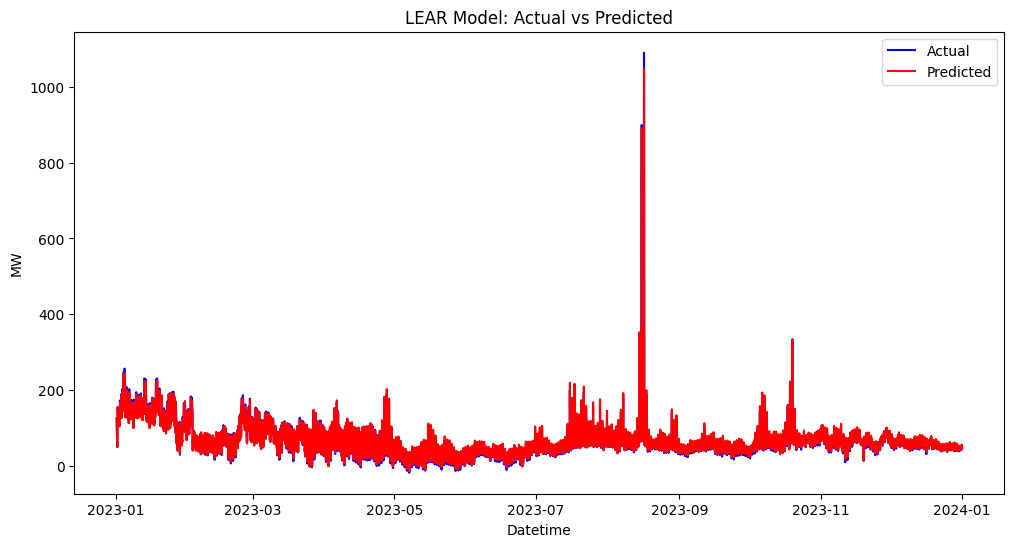

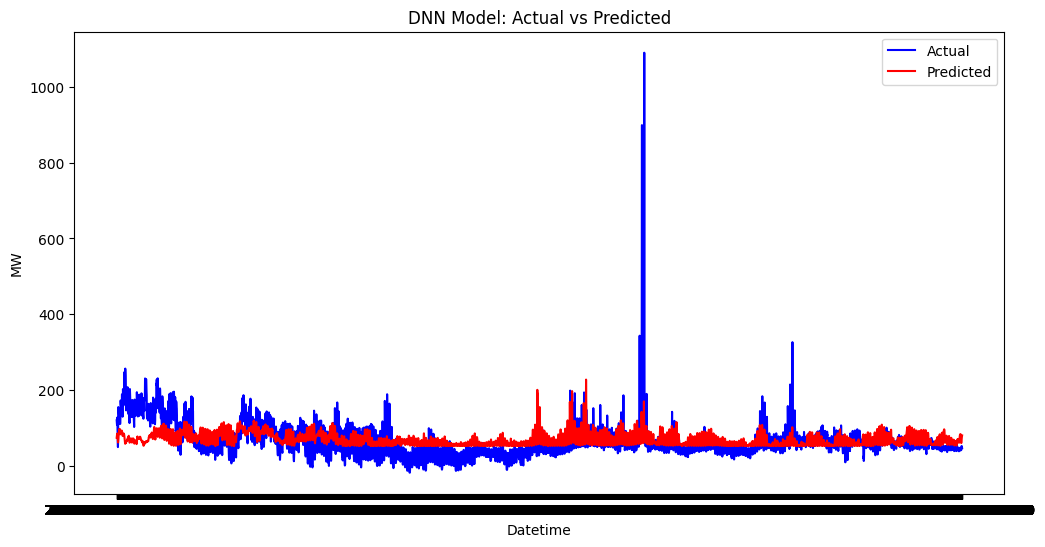

In [ ]:
import matplotlib.pyplot as plt


# For LEAR Model
datetime_lear_aligned = test_data_lear['Datetime'][-len(lear_predictions):]

# For DNN Model
datetime_dnn_aligned = test_data['Datetime'][-len(dnn_predictions):] 

# Plotting for LEAR model
plt.figure(figsize=(12, 6))
plt.plot(datetime_lear_aligned, y_test_lear[-len(lear_predictions):], label='Actual', color='blue')
plt.plot(datetime_lear_aligned, lear_predictions, label='Predicted', color='red')
plt.title('LEAR Model: Actual vs Predicted')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend()
plt.show()

# Plotting for DNN model
plt.figure(figsize=(12, 6))
plt.plot(datetime_dnn_aligned, y_test_dnn[-len(dnn_predictions):], label='Actual', color='blue')
plt.plot(datetime_dnn_aligned, dnn_predictions, label='Predicted', color='red')
plt.title('DNN Model: Actual vs Predicted')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend()
plt.show()


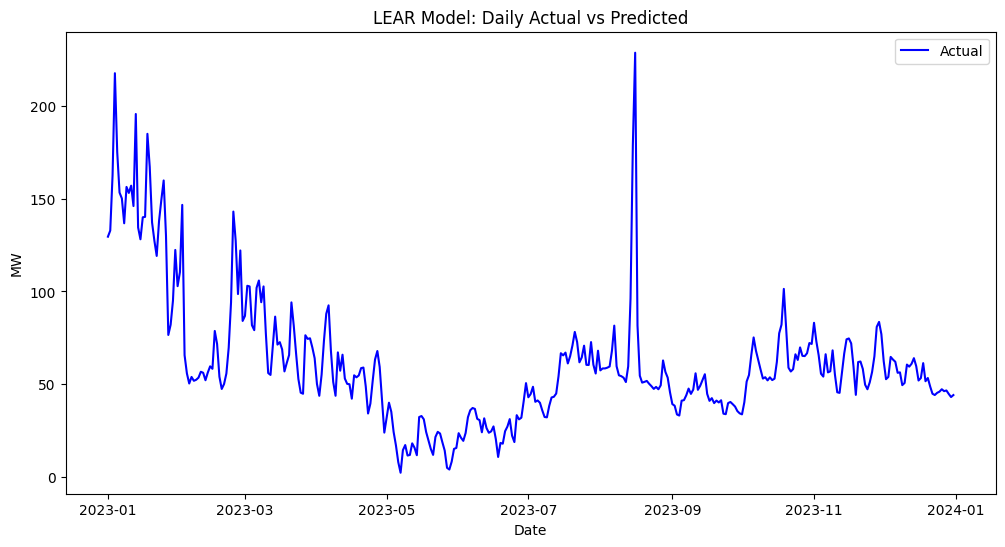

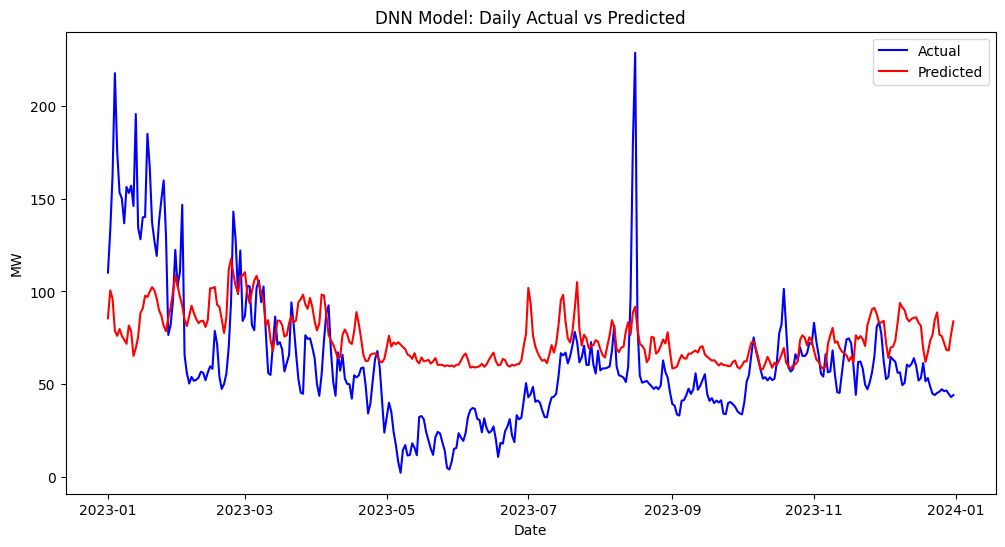

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure that 'Datetime' columns are in datetime format
test_data_lear['Datetime'] = pd.to_datetime(test_data_lear['Datetime'])
test_data['Datetime'] = pd.to_datetime(test_data['Datetime'])

# Aligning the datetime data for LEAR and DNN models
datetime_lear_aligned = test_data_lear['Datetime'][-len(lear_predictions):]
datetime_dnn_aligned = test_data['Datetime'][-len(dnn_predictions):]

# Convert datetime to date (to group by day)
datetime_lear_aligned = datetime_lear_aligned.dt.date
datetime_dnn_aligned = datetime_dnn_aligned.dt.date

# For LEAR model
lear_grouped = pd.DataFrame({'Datetime': datetime_lear_aligned, 'Actual': y_test_lear[-len(lear_predictions):], 'Predicted': lear_predictions})
lear_daily = lear_grouped.groupby('Datetime').mean()

# For DNN model
dnn_grouped = pd.DataFrame({'Datetime': datetime_dnn_aligned, 'Actual': y_test_dnn[-len(dnn_predictions):], 'Predicted': dnn_predictions})
dnn_daily = dnn_grouped.groupby('Datetime').mean()

# Plotting
# LEAR Model
plt.figure(figsize=(12, 6))
plt.plot(lear_daily.index, lear_daily['Actual'], label='Actual', color='blue')
# plt.plot(lear_daily.index, lear_daily['Predicted'], label='Predicted', color='red')
plt.title('LEAR Model: Daily Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('MW')
plt.legend()
plt.show()
plt.close()

# DNN Model
plt.figure(figsize=(12, 6))
plt.plot(dnn_daily.index, dnn_daily['Actual'], label='Actual', color='blue')
plt.plot(dnn_daily.index, dnn_daily['Predicted'], label='Predicted', color='red')
plt.title('DNN Model: Daily Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('MW')
plt.legend()
plt.show()
plt.close()


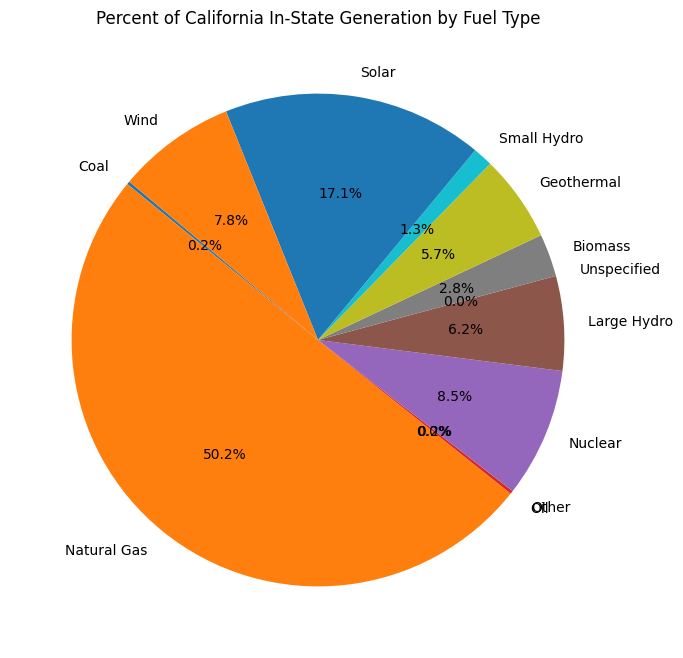

In [13]:
import matplotlib.pyplot as plt

# Data for California In-State Generation by Fuel Type
fuel_types = ['Coal', 'Natural Gas', 'Oil', 'Other', 'Nuclear', 'Large Hydro', 'Unspecified', 'Biomass', 'Geothermal', 'Small Hydro', 'Solar', 'Wind']
percent_generation = [0.2, 50.2, 0.0, 0.2, 8.5, 6.2, 0.0, 2.8, 5.7, 1.3, 17.1, 7.8]

# Creating a pie chart
plt.figure(figsize=(10, 8))
plt.pie(percent_generation, labels=fuel_types, autopct='%1.1f%%', startangle=140)
plt.title('Percent of California In-State Generation by Fuel Type')
plt.show()


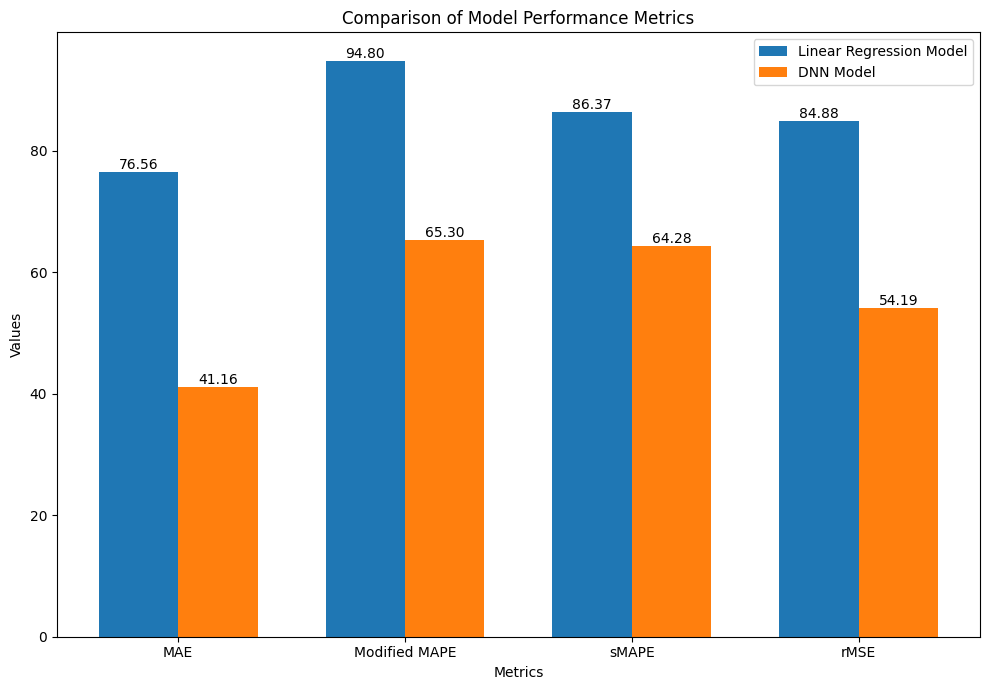

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Metric names
metrics = ['MAE', 'Modified MAPE', 'sMAPE', 'rMSE']

# Values for Linear Regression Model and DNN Model
linear_regression_values = [76.565, 94.801, 86.374, 84.878]
dnn_values = [41.164, 65.297, 64.278, 54.185]

# The x position for bars
bar_width = 0.35
index = np.arange(len(metrics))

# Plotting the bar chart
plt.figure(figsize=(10, 7))

# Create bars for Linear Regression and DNN, and add the values on top
bars1 = plt.bar(index, linear_regression_values, bar_width, label='Linear Regression Model')
bars2 = plt.bar(index + bar_width, dnn_values, bar_width, label='DNN Model')

# Add values on top of the bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

# General layout
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Model Performance Metrics')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

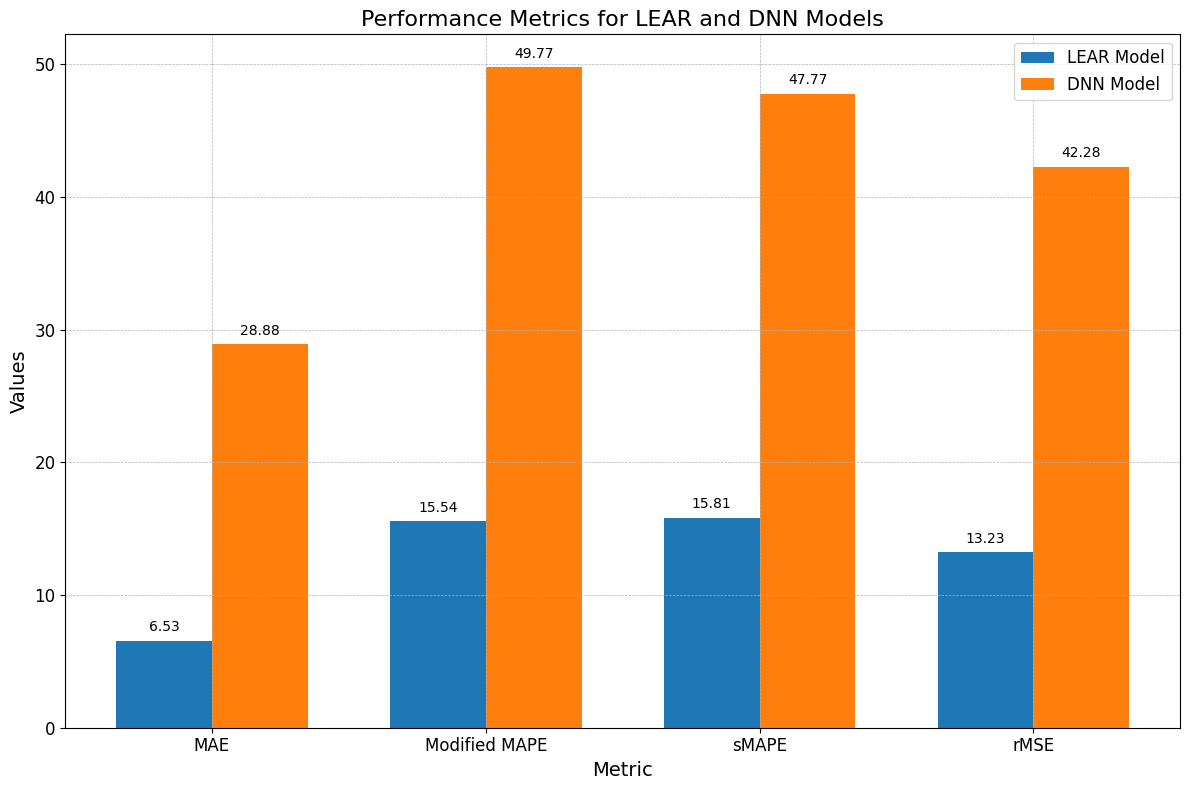

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Metric names
metrics = ['MAE', 'Modified MAPE', 'sMAPE', 'rMSE']

# Values for LEAR Model and DNN Model
lear_values = [6.533, 15.543, 15.809, 13.226]
dnn_values = [28.885, 49.768, 47.771, 42.278]

# The x position for bars
bar_width = 0.35
index = np.arange(len(metrics))

# Plotting the bar chart with improved color scheme
plt.figure(figsize=(12, 8))
bar1 = plt.bar(index, lear_values, bar_width, color='#1f77b4', label='LEAR Model')  # Blue color
bar2 = plt.bar(index + bar_width, dnn_values, bar_width, color='#ff7f0e', label='DNN Model')  # Orange color

# Adding the metric values on top of the bars
for bar in bar1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

for bar in bar2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

# General layout
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Performance Metrics for LEAR and DNN Models', fontsize=16)
plt.xticks(index + bar_width / 2, metrics, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [18]:
import pandas as pd

# Creating the data for the table
data = {
    "Market Type": ["Day-ahead", "Real-time", "Ancillary Services", "Capacity"],
    "Key Function": [
        "Scheduling and pricing electricity a day in advance",
        "Adjusting supply to meet actual demand in real time",
        "Providing support services for grid reliability",
        "Ensuring long-term resource availability"
    ],
    "Importance in Electricity Sector": [
        "Critical for demand prediction, generation planning, and price stability",
        "Essential for addressing immediate grid needs and balancing supply-demand",
        "Vital for maintaining grid stability and addressing unforeseen demand spikes",
        "Important for long-term reliability and operational planning"
    ]
}

# Creating a DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
df.head()


,Market Type,Key Function,Importance in Electricity Sector
0,Day-ahead,Scheduling and pricing electricity a day in ad...,"Critical for demand prediction, generation pla..."
1,Real-time,Adjusting supply to meet actual demand in real...,Essential for addressing immediate grid needs ...
2,Ancillary Services,Providing support services for grid reliability,Vital for maintaining grid stability and addre...
3,Capacity,Ensuring long-term resource availability,Important for long-term reliability and operat...


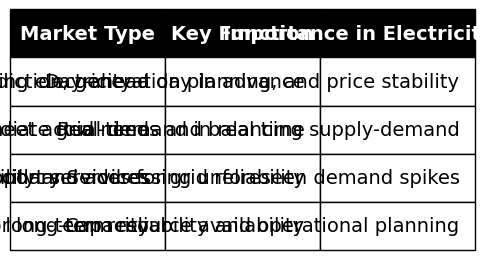

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Creating the data for the table
data = {
    "Market Type": ["Day-ahead", "Real-time", "Ancillary Services", "Capacity"],
    "Key Function": [
        "Scheduling and pricing electricity a day in advance",
        "Adjusting supply to meet actual demand in real time",
        "Providing support services for grid reliability",
        "Ensuring long-term resource availability"
    ],
    "Importance in Electricity Sector": [
        "Critical for demand prediction, generation planning, and price stability",
        "Essential for addressing immediate grid needs and balancing supply-demand",
        "Vital for maintaining grid stability and addressing unforeseen demand spikes",
        "Important for long-term reliability and operational planning"
    ]
}

# Creating a DataFrame
df = pd.DataFrame(data)

# Function to render dataframe as a pretty table using matplotlib
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='black', row_colors=['white', 'white'], edge_color='black',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors)])
    return ax

# Rendering the table using the function
render_mpl_table(df, header_columns=0, col_width=2.0)
plt.show()